# Multilayer perceptron

Pytorch framework documentation [here](https://pytorch.org/)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import time
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn

## Load data - [MNIST](http://yann.lecun.com/exdb/mnist/)

In [6]:
# Load MNIST data
data_train = pd.read_csv( "/content/sample_data/mnist_train_small.csv" , header=None)
data_test  = pd.read_csv( "/content/sample_data/mnist_test.csv" , header=None)


In [11]:
X_train = np.array(data_train.iloc[:, 1:])
y_train = np.array(data_train.iloc[:, 0 ])
X_test  = np.array(data_test.iloc[:, 1:])
y_test  = np.array(data_test.iloc[:, 0 ])

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20000, 784) (10000, 784) (20000,) (10000,)


In [12]:
# # create train / test splits
# X_train, X_test, y_train, y_test = _

# Reshape to bidimensional (image) size
X_train, X_test = X_train.reshape([-1, 28, 28]) , X_test.reshape([-1, 28, 28])

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20000, 28, 28) (10000, 28, 28) (20000,) (10000,)


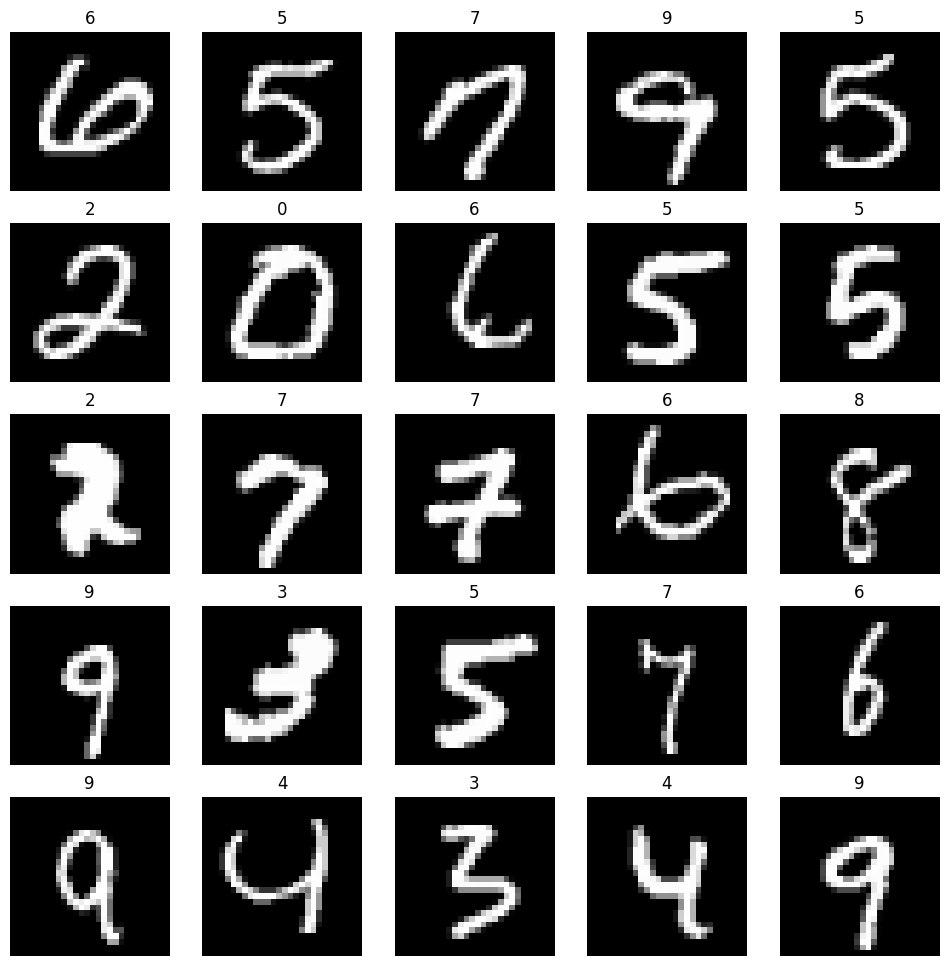

In [13]:
# Visualize grid of samples
grid_size = (5,5)

_, axes = plt.subplots ( grid_size[0] , grid_size[1] , figsize=(12,12))
axes = axes.ravel()

for i, ax in enumerate(axes):
  ax.imshow( X_train[i] , cmap='gray')
  ax.set_title(y_train[i])
  ax.set_axis_off()


In [15]:
labels, counts = np.unique(y_train, return_counts=True)
print (labels, counts)
print (X_train.max(), X_train.min())

[0 1 2 3 4 5 6 7 8 9] [1962 2243 1989 2021 1924 1761 2039 2126 1912 2023]
255 0


In [16]:
# Reshape the data - MLPs do not understand such '2D' stuff
# Reshape to 1D is similat to "flatten" an image

# Configuration options
feature_vector_length = 784
num_classes = 10

X_train = X_train.reshape([-1, 784])
X_test = X_test.reshape([-1, 784])

# Convert into 0 - 1 values
X_train = X_train / 255.
X_test = X_test / 255.

In [18]:
# Convert target classes to categorical ones - one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [19]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20000, 784) (10000, 784) (20000, 10) (10000, 10)


## Create a graph model

In [39]:
# Model params for training
epochs = 100
batch_size = 200 # We dont train the whole dataset at the time
losses = []

In [40]:
model = torch.nn.Sequential(
    nn.Linear( 784 , 392 ), #nn.ReLU(),
    nn.Linear( 392 , 196 ), #nn.ReLU(),
    nn.Linear( 196 , 98 ), #nn.ReLU(),
    # nn.Linear( _ , _ ), nn.ReLU(),
    # nn.Linear( _ , _ ), nn.ReLU(),
    nn.Linear( 98 , num_classes ) #, nn.Softmax()
)


## Define loss function and optimizer

In [41]:
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001 ) #Adam

## Train model

In [42]:
start_time = time.time()
progress = tqdm( range(epochs), ncols=100 )

for epoch in progress: # Iterate over all the num of epochs
  #
  batch_losses = 0

  for i in range(0, len(X_train), batch_size) : # Iterate over all batches of data
    #
    # First step, take the data from the dataset
    batch_X = X_train[i: i + batch_size]
    batch_y = y_train[i: i + batch_size]
    batch_X = torch.from_numpy(batch_X).to(torch.float32) # Convert to torch tensor to feed the graph
    batch_y = torch.from_numpy(batch_y).to(torch.float32) # Convert to torch tensor to feed the graph

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    predictions = model(batch_X)

    # Compute loss
    batch_loss = loss(predictions, batch_y)

    # Perform backward pass
    batch_loss.backward()

    # Optimize parameters
    optimizer.step()

    ## Accumulate loss to compute mean over all batches
    batch_losses += batch_loss.item()

    # Compute time and show all progress
    elapsed_time = time.time() - start_time

  # Save epoch loss
  epoch_loss = batch_losses/(len(X_train)/batch_size)
  losses.append(epoch_loss)

  progress.set_description("[Epoch %d/%d] [Loss: %f] time: %3f" % (epoch, epochs,
                                                                    epoch_loss,
                                                                    elapsed_time))


[Epoch 99/100] [Loss: 0.068642] time: 50.569124: 100%|████████████| 100/100 [00:50<00:00,  1.98it/s]


## Plot results

Text(0.5, 1.0, 'Loss (MSE)')

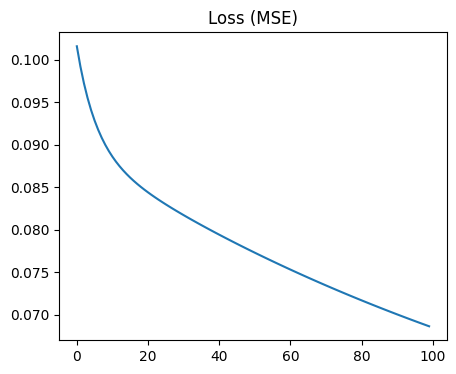

In [43]:
# Plot progress (loss function)

_, ax = plt.subplots(figsize=(5,4))
ax.plot(np.arange(len(losses)), losses)
ax.set_title("Loss (MSE)")

## Compute metrics over ```X_test``` images

100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 464.51it/s]


acc: 0.6618


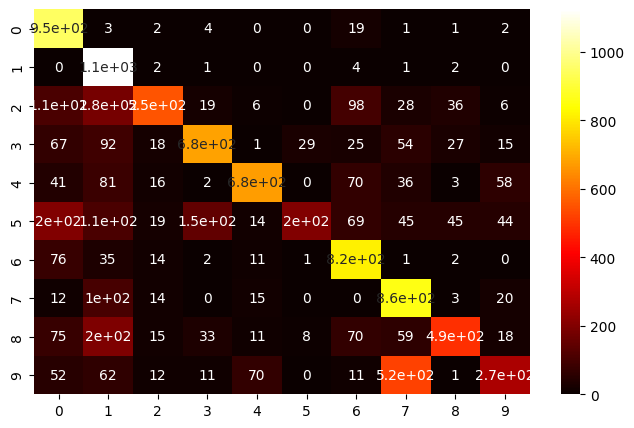

In [44]:
progress = tqdm(range( 0 , len(X_test) , batch_size ), ncols=100)
predictions = []

for i in progress : # Iterate over all batches of data
  #
  batch_X = X_test[i: i + batch_size]
  batch_y = y_test[i: i + batch_size]
  batch_X = torch.from_numpy(batch_X).to(torch.float32)

  # Perform forward pass to compute predictions
  batch_predictions = model(batch_X)
  predictions.extend(batch_predictions.detach().numpy())

y_test_ = np.argmax(y_test, axis=1)
predictions = np.argmax(np.array(predictions), axis=1)
acc = accuracy_score(y_test_, predictions)
cm_ = confusion_matrix(y_test_, predictions)

# Compute confusion matrix and accuracy
_, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_, cmap="hot", annot=True, ax=ax)
print("acc: {0}".format(acc))